In [ ]:
from tensorflow.python.client import device_lib
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print(device_lib.list_local_devices())


In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from itertools import combinations

from fredapi import Fred

from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Bidirectional, InputLayer
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import lightgbm as lgb
import GPyOpt

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")


In [3]:
fred = Fred(api_key="YOUR API KEY HERE")
# data = fred.get_series_as_of_date("series", "date")
# fred.get_series()
# fred.get_series_latest_release()


# fred.search("DGS10").T # 10 yr treasury
# fred.search("EFFR") # federal fund rate
# fred.search("USSTHPI") # HOUSEPRICEINDEX
# fred.search("M2REAL") # M2Real
# fred.search("MORTGAGE30US") # MORTGAGE30US
# fred.search("GDPC1") # REALGDP
# fred.search("A939RX0Q048SBEA") # REALGDPPC
# fred.search("GPDIC1") # Real gross private domestic investment
# fred.search("UNRATE") # Unemployment rate
# fred.search("VIXCLS") # VIXCLS


In [4]:
# goal is to predict unemployment rate
target = "UNRATE"

# collect data from all csvs, aggregate by month
All_data = pd.DataFrame(fred.get_series_latest_release("UNRATE"))
All_data = All_data.reset_index()
All_data.columns = ["DATE", "UNRATE"]

All_data["Year"] = pd.DatetimeIndex(All_data["DATE"]).year
All_data["Month"] = pd.DatetimeIndex(All_data["DATE"]).month
All_data = All_data.loc[All_data["Year"] >= 1980]
All_data = All_data.drop(["DATE"], axis=1)
All_data


,UNRATE,Year,Month
384,6.3,1980,1
385,6.3,1980,2
386,6.3,1980,3
387,6.9,1980,4
388,7.5,1980,5
...,...,...,...
878,6.0,2021,3
879,6.1,2021,4
880,5.8,2021,5
881,5.9,2021,6


In [5]:
# aggregate 10YRTREASURY by month
tempdf = pd.DataFrame(fred.get_series_latest_release("DGS10"))
tempdf = tempdf.reset_index()
tempdf.columns = ["DATE", "10YRTREASURY"]

tempdf["Year"] = pd.DatetimeIndex(tempdf["DATE"]).year
tempdf["Month"] = pd.DatetimeIndex(tempdf["DATE"]).month
tempdf["10YRTREASURY"] = tempdf["10YRTREASURY"].replace(".", method="ffill")
tempdf["10YRTREASURY"] = tempdf["10YRTREASURY"].replace(".", 0, method="pad")
tempdf["10YRTREASURY"] = tempdf["10YRTREASURY"].astype(float)

tempdf = tempdf.loc[tempdf["Year"] >= 1980]

tempdf = tempdf.groupby(["Year", "Month"], as_index=False).agg(
    {"10YRTREASURY": ["mean", "std"]})
tempdf.columns = ["".join(col).strip() for col in tempdf.columns.values]
All_data = All_data.merge(tempdf, on=["Year", "Month"])


# fedfundrate series does not include data from 1980 onward anymore so I will be using a previously downloaded csv
# to fill in older dates
ffr = pd.read_csv("FedFundRate.csv")
ffr["Year"] = pd.DatetimeIndex(ffr["DATE"]).year
ffr["Month"] = pd.DatetimeIndex(ffr["DATE"]).month
ffr = ffr.loc[ffr["Year"] < 2020]

tempdf = pd.DataFrame(fred.get_series_latest_release("EFFR"))
tempdf = tempdf.reset_index()
tempdf.columns = ["DATE", "FEDFUNDRATE"]

tempdf["Year"] = pd.DatetimeIndex(tempdf["DATE"]).year
tempdf["Month"] = pd.DatetimeIndex(tempdf["DATE"]).month

tempdf = tempdf.loc[tempdf["Year"] >= 2020]
tempdf = pd.concat([ffr, tempdf])
tempdf = tempdf.drop(["DATE"], axis=1)
tempdf = tempdf.fillna(method="ffill")

tempdf = tempdf.groupby(["Year", "Month"], as_index=False).agg(
    {"FEDFUNDRATE": ["mean", "std"]})
tempdf.columns = ["".join(col).strip() for col in tempdf.columns.values]
All_data = All_data.merge(tempdf, on=["Year", "Month"])

tempdf = pd.DataFrame(fred.get_series_latest_release("M2REAL"))
tempdf = tempdf.reset_index()
tempdf.columns = ["DATE", "M2REAL"]

tempdf["Year"] = pd.DatetimeIndex(tempdf["DATE"]).year
tempdf["Month"] = pd.DatetimeIndex(tempdf["DATE"]).month

tempdf = tempdf.loc[tempdf["Year"] >= 1980]

tempdf = tempdf.drop(["DATE"], axis=1)
All_data = All_data.merge(tempdf, on=["Year", "Month"])

tempdf = pd.DataFrame(fred.get_series_latest_release("MORTGAGE30US"))
tempdf = tempdf.reset_index()
tempdf.columns = ["DATE", "MORTGAGE30US"]

tempdf["Year"] = pd.DatetimeIndex(tempdf["DATE"]).year
tempdf["Month"] = pd.DatetimeIndex(tempdf["DATE"]).month

tempdf = tempdf.loc[tempdf["Year"] >= 1980]

tempdf = tempdf.groupby(["Year", "Month"], as_index=False).agg(
    {"MORTGAGE30US": ["mean", "std"]})
tempdf.columns = ["".join(col).strip() for col in tempdf.columns.values]
All_data = All_data.merge(tempdf, on=["Year", "Month"])

tempdf = pd.DataFrame(fred.get_series_latest_release("VIXCLS"))
tempdf = tempdf.reset_index()
tempdf.columns = ["DATE", "VIXCLS"]

tempdf["Year"] = pd.DatetimeIndex(tempdf["DATE"]).year
tempdf["Month"] = pd.DatetimeIndex(tempdf["DATE"]).month
tempdf["VIXCLS"] = tempdf["VIXCLS"].replace(".", method="ffill")
tempdf["VIXCLS"] = tempdf["VIXCLS"].astype(float)

tempdf = tempdf.loc[tempdf["Year"] >= 1980]

tempdf = tempdf.groupby(["Year", "Month"], as_index=False).agg(
    {"VIXCLS": ["mean", "std"]})
tempdf.columns = ["".join(col).strip() for col in tempdf.columns.values]
All_data = All_data.merge(tempdf, how="left", on=["Year", "Month"])

All_data["Date_block_num"] = All_data["Month"] + ((All_data["Year"]-1980)*12)

All_data


,UNRATE,Year,Month,10YRTREASURYmean,10YRTREASURYstd,FEDFUNDRATEmean,FEDFUNDRATEstd,M2REAL,MORTGAGE30USmean,MORTGAGE30USstd,VIXCLSmean,VIXCLSstd,Date_block_num
0,6.3,1980,1,10.802273,0.232316,13.816774,0.502728,1900.9,12.8775,0.022174,NaN,NaN,1
1,6.3,1980,2,12.414737,0.735296,14.126207,1.258234,1891.9,13.0400,0.316386,NaN,NaN,2
2,6.3,1980,3,12.749048,0.254104,17.192258,1.328858,1872.4,15.2825,0.892875,NaN,NaN,3
3,6.9,1980,4,11.473333,0.701123,17.607667,1.857324,1856.9,16.3250,0.050000,NaN,NaN,4
4,7.5,1980,5,10.181429,0.193269,10.983226,1.634963,1851.0,14.2620,1.092712,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,6.0,2021,3,1.610870,0.092683,0.069565,0.002085,7520.4,3.0825,0.065000,21.843043,2.659558,495
495,6.1,2021,4,1.635000,0.050309,0.068636,0.004676,7541.4,3.0600,0.092466,17.416190,0.689619,496
496,5.8,2021,5,1.621000,0.033857,0.059048,0.003008,7586.2,2.9625,0.026300,19.760500,2.592200,497
497,5.9,2021,6,1.519091,0.052090,0.077273,0.019804,7523.6,2.9750,0.038730,16.956818,1.201845,498


In [6]:
# begin quarterly data
tempdf = pd.DataFrame(fred.get_series_latest_release("USSTHPI"))
tempdf = tempdf.reset_index()
tempdf.columns = ["DATE", "USSTHPI"]

tempdf["Year"] = pd.DatetimeIndex(tempdf["DATE"]).year
tempdf["Month"] = pd.DatetimeIndex(tempdf["DATE"]).month

tempdf = tempdf.loc[tempdf["Year"] >= 1980]

tempdf = tempdf.drop(["DATE"], axis=1)
All_data = All_data.merge(tempdf, how="left", on=["Year", "Month"])
All_data["USSTHPI"] = All_data["USSTHPI"].interpolate(method="spline", order=3)

tempdf = pd.DataFrame(fred.get_series_latest_release("GDPC1"))
tempdf = tempdf.reset_index()
tempdf.columns = ["DATE", "REALGDPUS"]

tempdf["Year"] = pd.DatetimeIndex(tempdf["DATE"]).year
tempdf["Month"] = pd.DatetimeIndex(tempdf["DATE"]).month

tempdf = tempdf.loc[tempdf["Year"] >= 1980]

tempdf = tempdf.drop(["DATE"], axis=1)
All_data = All_data.merge(tempdf, how="left", on=["Year", "Month"])
All_data["REALGDPUS"] = All_data["REALGDPUS"].interpolate(
    method="polynomial", order=3)

tempdf = pd.DataFrame(fred.get_series_latest_release("A939RX0Q048SBEA"))
tempdf = tempdf.reset_index()
tempdf.columns = ["DATE", "REALGDPPCUS"]

tempdf["Year"] = pd.DatetimeIndex(tempdf["DATE"]).year
tempdf["Month"] = pd.DatetimeIndex(tempdf["DATE"]).month

tempdf = tempdf.loc[tempdf["Year"] >= 1980]

tempdf = tempdf.drop(["DATE"], axis=1)
All_data = All_data.merge(tempdf, how="left", on=["Year", "Month"])
All_data["REALGDPPCUS"] = All_data["REALGDPPCUS"].interpolate(
    method="polynomial", order=3)

tempdf = pd.DataFrame(fred.get_series_latest_release("GPDIC1"))
tempdf = tempdf.reset_index()
tempdf.columns = ["DATE", "GPDIC1"]

tempdf["Year"] = pd.DatetimeIndex(tempdf["DATE"]).year
tempdf["Month"] = pd.DatetimeIndex(tempdf["DATE"]).month

tempdf = tempdf.loc[tempdf["Year"] >= 1980]

tempdf = tempdf.drop(["DATE"], axis=1)
All_data = All_data.merge(tempdf, how="left", on=["Year", "Month"])
All_data["GPDIC1"] = All_data["GPDIC1"].interpolate(
    method="polynomial", order=3)

All_data = All_data.loc[All_data["Year"] >= 1990]
All_data


,UNRATE,Year,Month,10YRTREASURYmean,10YRTREASURYstd,FEDFUNDRATEmean,FEDFUNDRATEstd,M2REAL,MORTGAGE30USmean,MORTGAGE30USstd,VIXCLSmean,VIXCLSstd,Date_block_num,USSTHPI,REALGDPUS,REALGDPPCUS,GPDIC1
120,5.4,1990,1,8.206667,0.195329,8.229032,0.094740,2483.8,9.8950,0.111505,23.347273,2.988829,121,165.240000,9364.259000,37617.000000,1252.058000
121,5.3,1990,2,8.473158,0.088069,8.237143,0.047909,2483.8,10.1975,0.087702,23.262632,1.374057,122,164.529206,9383.541894,37659.197921,1254.331926
122,5.2,1990,3,8.588636,0.059305,8.276774,0.055280,2480.6,10.2680,0.048683,20.062273,1.276979,123,164.938926,9392.411765,37655.034303,1254.283726
123,5.4,1990,4,8.785500,0.194624,8.255000,0.070307,2483.8,10.3700,0.146287,21.403500,1.484748,124,165.940000,9398.243000,37636.000000,1252.449000
124,5.4,1990,5,8.758182,0.155062,8.176452,0.181632,2479.2,10.4775,0.157348,18.097727,0.948347,125,165.729155,9405.937588,37623.379142,1248.866619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,6.0,2021,3,1.610870,0.092683,0.069565,0.002085,7520.4,3.0825,0.065000,21.843043,2.659558,495,494.904066,19315.656930,58334.918069,3517.062205
495,6.1,2021,4,1.635000,0.050309,0.068636,0.004676,7541.4,3.0600,0.092466,17.416190,0.689619,496,500.670355,19358.176000,58447.000000,3510.320000
496,5.8,2021,5,1.621000,0.033857,0.059048,0.003008,7586.2,2.9625,0.026300,19.760500,2.592200,497,506.973416,NaN,NaN,NaN
497,5.9,2021,6,1.519091,0.052090,0.077273,0.019804,7523.6,2.9750,0.038730,16.956818,1.201845,498,513.846500,NaN,NaN,NaN


In [7]:
# if data does not exist assume it is unchanged from previous entry
All_data = All_data.ffill(axis=1)


In [8]:
All_data.describe()


,UNRATE,Year,Month,10YRTREASURYmean,10YRTREASURYstd,FEDFUNDRATEmean,FEDFUNDRATEstd,M2REAL,MORTGAGE30USmean,MORTGAGE30USstd,VIXCLSmean,VIXCLSstd,Date_block_num,USSTHPI,REALGDPUS,REALGDPPCUS,GPDIC1
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,5.915567,2005.295515,6.453826,4.338088,0.093574,2.771990,0.105024,3742.812665,6.010918,0.076744,19.494776,1.854040,310.000000,298.534148,14225.329630,47726.090898,2337.323770
std,1.722676,9.131448,3.451839,2.022820,0.044513,2.380188,0.123246,1327.521588,1.906387,0.048288,7.713801,1.540956,109.552118,90.939347,3197.926266,7536.067134,698.076348
min,3.500000,1990.000000,1.000000,0.623636,0.017874,0.048636,0.000000,2305.100000,2.684000,0.009574,10.125455,0.302895,121.000000,164.529206,506.973416,506.973416,506.973416
25%,4.700000,1997.000000,3.000000,2.541136,0.061837,0.194500,0.015180,2488.150000,4.197000,0.041883,13.967446,0.971546,215.500000,205.764638,11672.932499,42627.528563,1873.595277
50%,5.600000,2005.000000,6.000000,4.257273,0.085464,2.274194,0.055280,3358.000000,6.068000,0.067577,17.569545,1.387526,310.000000,312.760000,14956.291000,49742.610234,2336.954074
75%,6.800000,2013.000000,9.000000,5.922857,0.112813,5.224408,0.154951,4629.300000,7.473500,0.095445,23.171263,2.254353,404.500000,366.246377,16515.328118,52211.730606,2804.556753
max,14.800000,2021.000000,12.000000,8.893158,0.334787,8.288667,0.945154,7586.200000,10.477500,0.270355,62.668947,14.560762,499.000000,521.322858,19358.176000,58543.075300,3561.893000


In [12]:
def make_multiplicative_features(df):
    columns = list(df.columns)
    for col in [target, "Year", "Month", "Date_block_num"]:
        columns.remove(col)
    df_copy = df.copy()
    for combo in list(combinations(columns, 2)):
        col1, col2 = combo
        new_col_name = col1 + "_dot_" + col2
        df_copy[new_col_name] = df_copy[col1] * df_copy[col2]
    return df_copy


All_data = make_multiplicative_features(All_data)


In [14]:
def lag_feature(df, lags, col):
    tmp = df[['Date_block_num', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['Date_block_num', col+'_lag_'+str(i)]
        shifted['Date_block_num'] += i
        df = pd.merge(df, shifted, on=['Date_block_num'], how='left')
    return df


In [15]:
All_data = lag_feature(All_data, [1, 2, 3, 4, 5, 6, 12], target)
All_data.fillna(0, inplace=True)


<AxesSubplot:>

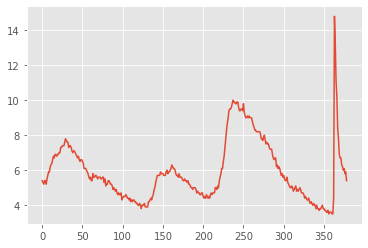

In [18]:
plt.figure()
All_data["UNRATE"].plot()


In [19]:
time_window_size = 50
features_size = len(All_data.columns) - 2  # disclude date and target variable


In [21]:
def make_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(InputLayer((time_window_size, features_size)))
    lstm_model.add(Bidirectional(
        LSTM(100, stateful=False, return_sequences=True)))
    lstm_model.add(Bidirectional(
        LSTM(100, stateful=False, return_sequences=False)))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer=Adam(), loss="mse")
    return lstm_model


In [22]:
def make_lstm_dataset(data, window_size=time_window_size):
    # data will be shape (n_steps, n_features)
    #returns (n_batches, window_size, n_features), (n_batches, 1)
    # target variable will be the last column in the input data
    lstm_x, lstm_y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i+window_size), :]
        lstm_x.append(window)
        lstm_y.append(data[i+window_size, -1])

    return np.array(lstm_x), np.array(lstm_y)[:, np.newaxis]


In [23]:
def make_ffn():
    ffn = Sequential()
    ffn.add(InputLayer((features_size-1)))
    ffn.add(Dense(256, activation="relu"))
    ffn.add(Dense(256, activation="relu"))
    ffn.add(Dense(128, activation="relu"))
    ffn.add(Dense(1))
    ffn.compile(optimizer=Adam(), loss="mse")
    return ffn


Bayesian hyperparameter tuning for lgbm

In [47]:
X_t = All_data.drop([target, "Year", "Month"], axis=1).values[:-70]
y_t = All_data['UNRATE'].values[1:-69]
X_v = All_data.drop([target, 'Year', 'Month'], axis=1).values[-70:-20]
y_v = All_data['UNRATE'].values[-69:-19]


In [49]:
def f_lgb(parameters):
    parameters = parameters[0]

    lgb_params = {'objective': 'mse',
                  'nthread': -1,
                  'bagging_seed': 2**7,
                  'verbose': 0,
                  'force_col_wise': True,
                  'reg_alpha': parameters[0],
                  'reg_lambda': parameters[1],
                  'feature_fraction': parameters[2],
                  'learning_rate': parameters[3],
                  'min_data_in_leaf': int(parameters[4]),
                  'num_leaves': int(parameters[5]),
                  'max_depth': int(parameters[6])}

    lgb_data_train = lgb.Dataset(X_t, y_t)
    lgb_data_valid = lgb.Dataset(X_v, y_v)

    temp_lgb = lgb.train(lgb_params, train_set=lgb_data_train,
                         valid_sets=[lgb_data_train, lgb_data_valid], valid_names=["train", "valid"])

    score = temp_lgb.best_score['valid']['l2']
    print(score)
    return score


In [50]:
# Bounds (NOTE: define continuous variables first, then discrete!)
lgb_bounds = [
    {'name': 'reg_alpha',
     'type': 'continuous',
     'domain': (0, 5)},

    {'name': 'reg_lambda',
     'type': 'continuous',
     'domain': (0, 5)},

    {'name': 'feature_fraction',
     'type': 'continuous',
     'domain': (0.01, 1)},

    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0.001, 2)},

    {'name': 'min_data_in_leaf',
     'type': 'continuous',
     'domain': (1, 5)},

    {'name': 'num_leaves',
     'type': 'continuous',
     'domain': (2, 20)},

    {'name': 'max_depth',
     'type': 'continuous',
     'domain': (1, 2)}]


In [ ]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f=f_lgb, domain=lgb_bounds,
    acquisition_type='MPI',
    acquisition_par=0.1,
    exact_eval=True,
    maximize=False)
optimizer.run_optimization(max_iter=100)


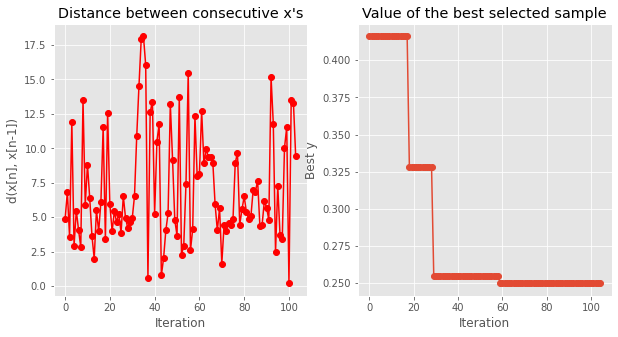

In [32]:
optimizer.plot_convergence()


In [33]:
optimizer.X[np.argmin(optimizer.Y)]


array([ 0.84830028,  0.12583606,  0.4198275 ,  1.13548059,  4.01392312,
       16.98036646,  1.36880197])

In [25]:
lgb_params = {'objective': 'mse',
              'nthread': -1,
              'bagging_seed': 2**7,
              'verbose': 0,
              'force_col_wise': True,
              'reg_alpha': 0.3072275,
              'reg_lambda': 3.85862695,
              'feature_fraction': 0.58243646,
              'learning_rate': 1.1126115,
              'min_data_in_leaf': 2,
              'num_leaves': 6,
              'max_depth': 1}


Model training and predictions

In [28]:
# goal is to use an ensemble of models to predict unemployment in the next month

low_date_block_num = 200
high_date_block_num = int(All_data["Date_block_num"].max())

y_train_level2 = All_data.loc[(All_data["Date_block_num"] > low_date_block_num) & (
    All_data["Date_block_num"] <= high_date_block_num), target]
X_train_level2 = np.zeros([y_train_level2.shape[0], 8])  # 9])


lstm_model = make_lstm_model()
lstm_default_weights = lstm_model.get_weights()
ffn_model = make_ffn()
ffn_default_weights = ffn_model.get_weights()


last_block_end = 0
for cur_block_num in tqdm(range(low_date_block_num, high_date_block_num)):

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = All_data.loc[All_data["Date_block_num"] < cur_block_num].drop(
        [target, "Year", "Month"], axis=1)
    X_train = scaler.fit_transform(X_train)

    X_valid = All_data.loc[All_data["Date_block_num"] ==
                           cur_block_num].drop([target, "Year", "Month"], axis=1)
    X_valid = scaler.transform(X_valid)

    y_train = All_data.loc[All_data["Date_block_num"]
                           <= cur_block_num, target].values[1:]
    y_valid = All_data.loc[All_data["Date_block_num"]
                           == cur_block_num + 1, target].values

    # 1.lstm
    lstm_model.set_weights(lstm_default_weights)

    X_train_lstm, y_train_lstm = make_lstm_dataset(
        np.concatenate((X_train, y_train[:, np.newaxis]), axis=1))

    X_valid_lstm = np.concatenate((X_train[-time_window_size:, :],
                                   y_train[-time_window_size:][:, np.newaxis]), axis=1)[np.newaxis, :, :]
    y_valid_lstm = y_valid[:, np.newaxis]

    lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20,
                   validation_data=(X_valid_lstm, y_valid_lstm),
                   shuffle=False, verbose=0)
    lstm_pred = lstm_model.predict(X_valid_lstm)

    # 2.fully connected feed forward network
    ffn_model.set_weights(ffn_default_weights)
    ffn_model.fit(X_train, y_train, epochs=20, shuffle=False, verbose=0)
    ffn_pred = ffn_model.predict(X_valid)

    # 3.linear regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_valid)

    # 4.lightgbm
    lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
    lgb_pred = lgb_model.predict(X_valid)

    # 5.random forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_valid)

    # 6.kneighbors regression
    knr = KNeighborsRegressor()
    knr.fit(X_train, y_train)
    knr_pred = knr.predict(X_valid)

    # 7.Support vector regression
    svr = SVR()
    svr.fit(X_train, y_train)
    svr_pred = svr.predict(X_valid)

    # 8.Gaussian Process regression
    gpr = GaussianProcessRegressor(kernel=RBF(), normalize_y=True)
    gpr.fit(X_train, y_train)
    gpr_pred = gpr.predict(X_valid)

    # 9.collect metafeatures into matrix
    block_len = len(y_valid)
    if last_block_end == 0:
        start = 0
    else:
        start = last_block_end
    end = start + block_len
    last_block_end = end

    X_train_level2[start:end, :] = np.c_[lstm_pred,
                                         ffn_pred,
                                         lr_pred,
                                         lgb_pred,
                                         rf_pred,
                                         knr_pred,
                                         svr_pred,
                                         gpr_pred]
print("finished")


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:36<00:00,  4.15s/it]

finished


In [26]:
X_train_level2 = np.load("./x_train_level2.npy")
low_date_block_num = 200
high_date_block_num = int(All_data["Date_block_num"].max()-1)
y_train_level2 = All_data.loc[(All_data["Date_block_num"] > low_date_block_num) & (
    All_data["Date_block_num"] <= high_date_block_num), target]


In [27]:
ensemble_stack = LinearRegression()
ensemble_stack.fit(X_train_level2, y_train_level2)
stack_preds = ensemble_stack.predict(X_train_level2)
r2_stack = r2_score(y_train_level2, stack_preds)
print('Train R-squared for stacking is %f' % r2_stack)
print('Train MSE is %f' % mean_squared_error(y_train_level2, stack_preds))


Train R-squared for stacking is 0.838587
Train MSE is 0.572272


In [154]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [219]:
ensemble_stack = sm.OLS(y_train_level2.values, X_train_level2).fit()
stack_preds = ensemble_stack.predict()
print(ensemble_stack.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              2323.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):                   5.73e-258
Time:                        03:40:02   Log-Likelihood:                         -339.74
No. Observations:                 298   AIC:                                      695.5
Df Residuals:                     290   BIC:                                      725.1
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Analysis

- Lstm and random forest models were able to predict future unemployment reasonably well
- linear regression and KNeighborsRegression were practically useless predictors
- lightGBM did very poorly predicting future unemployment

##### Final thoughts:
I expected Lstm to outperform all other models and was surprised to see RandomForests perform much better than Lstm.

KNeighborsRegression seems to not be able to adapt to a rapidly changing state of the economy as it tries to compare points that are similar without taking into account their contexts.

As Linear Regression is used heavily in consulting and was a significant portion of my economics education. Its lackluster performance gives me a great deal of hope for greater adoption of machine learning models within economics.

I suspect lightGBM did not perform well here due to the relatively low quantity of data as it performs best in data-intensive workloads.

In [ ]:
def make_graph(original_data, yhat, y_train_level2, confidence=False,
               target="UNRATE", target_rename="Unemployment rate", title="Unemployment rate in the US",
               ylabel="rate (US percentage)", save_as="STACK.png", model_name="stacking", model=None):
    y = original_data.loc[(original_data["Date_block_num"] > low_date_block_num) &
                          (original_data["Date_block_num"] <= high_date_block_num), target]
    df = pd.DataFrame(y)
    df.columns = [target_rename]
    df["prediction"] = yhat
    if confidence:
        _, lower_confidence, upper_confidence = wls_prediction_std(model)
        df["lower_confidence"] = lower_confidence
        df["upper_confidence"] = upper_confidence
    df[["Year", "Month"]] = original_data.loc[(original_data["Date_block_num"] > low_date_block_num) &
                                              (original_data["Date_block_num"] <= high_date_block_num), ["Year", "Month"]]
    df = df.loc[(df["Year"] > min(df["Year"]))]

    df["date"] = df["Year"].astype(int).apply(
        str) + "-" + df["Month"].astype(int).apply(str)
    df = df.drop(["Year", "Month"], axis=1)
    df = df.set_index(["date"])
    r2_model = r2_score(y_train_level2, yhat)
    mse_stack = mean_squared_error(y, yhat)
    caption = "Train R-squared for " + model_name + \
        " is %f" % r2_model + "\n" + "Train MSE is %f" % mse_stack
    fig, ax = plt.subplots(figsize=(15, 10))

    target_ax = ax.plot(df.index, df[target_rename], "b", label=target_rename)
    pred_ax = ax.plot(df.index, df.prediction, "g", label="Prediction")
    if confidence:
        confidence_ax = ax.fill_between(
            df.index, df.lower_confidence, df.upper_confidence, color="y", alpha=0.1, label="95% confidence")
    plt.legend(loc=2, prop={'size': 20})
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("date", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticks(range(0, len(df.index), 12))
    ax.set_xticklabels([i for n, i in enumerate(df.index) if n % 12 == 0],
                       fontsize=20, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(int(min(y))-1, int(max(y))+1))
    ax.set_yticklabels(range(int(min(y))-1, int(max(y))+1), fontsize=20)
    ax.set_ylim(max(0, int(min(y))-1), int(max(y))+1)
    ax.text(2, 11.8, caption, fontsize=12)
    fig = ax.get_figure()
    fig.savefig(save_as)

    if confidence:
        # produce residual plots
        for i in range(1, 8):
            fig = plt.figure(figsize=(12, 8))
            fig = sm.graphics.plot_regress_exog(model, "x" + str(i), fig=fig)
            fig.savefig("residualplot" + str(i) + ".png")


make_graph(All_data, stack_preds, y_train_level2, True, model=ensemble_stack)


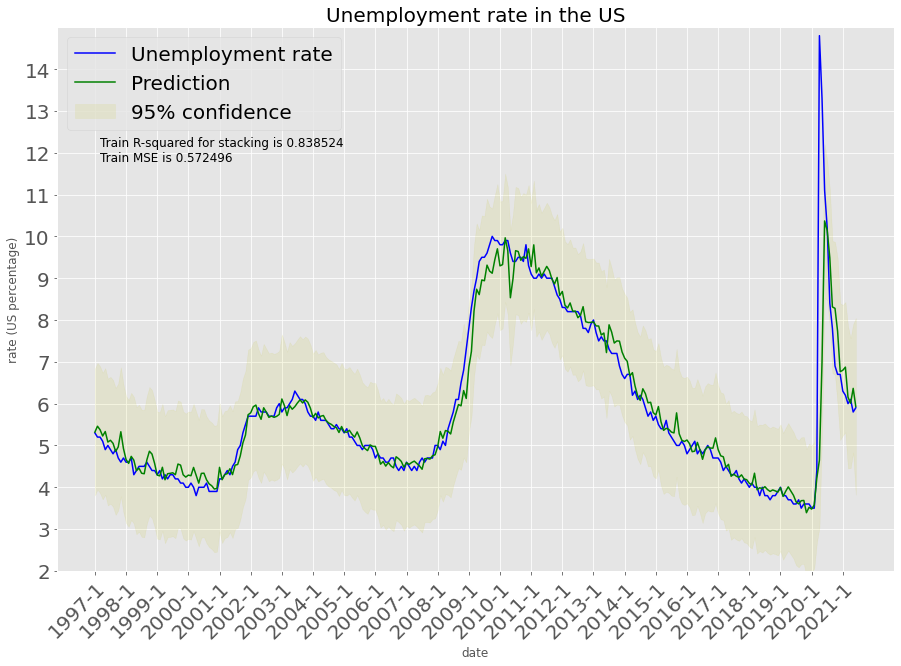

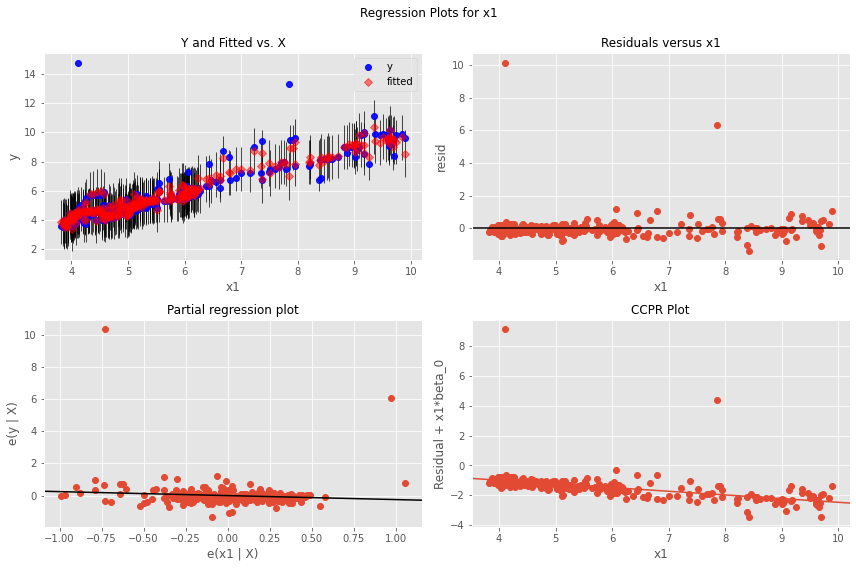

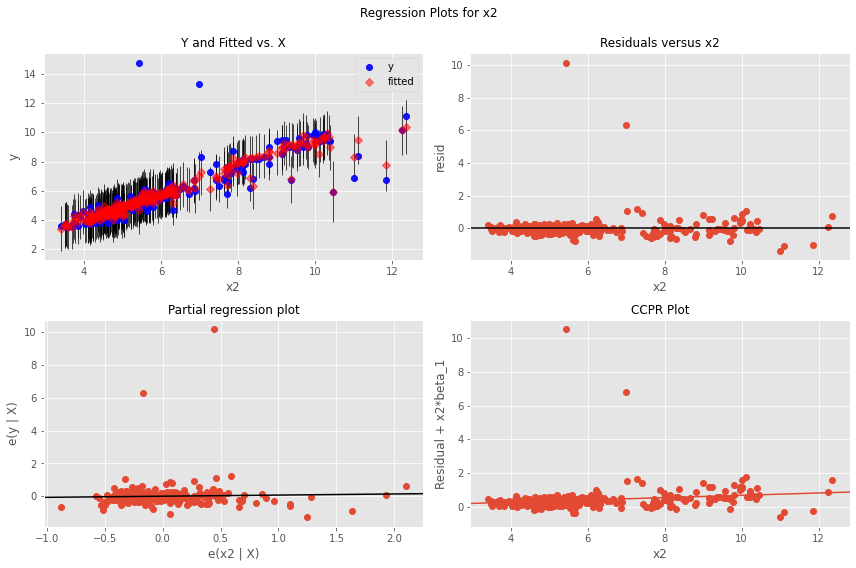

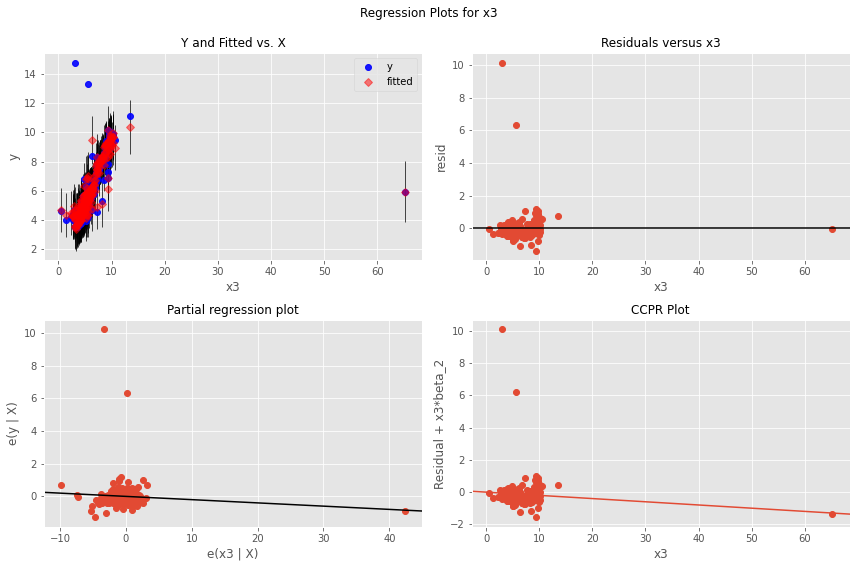

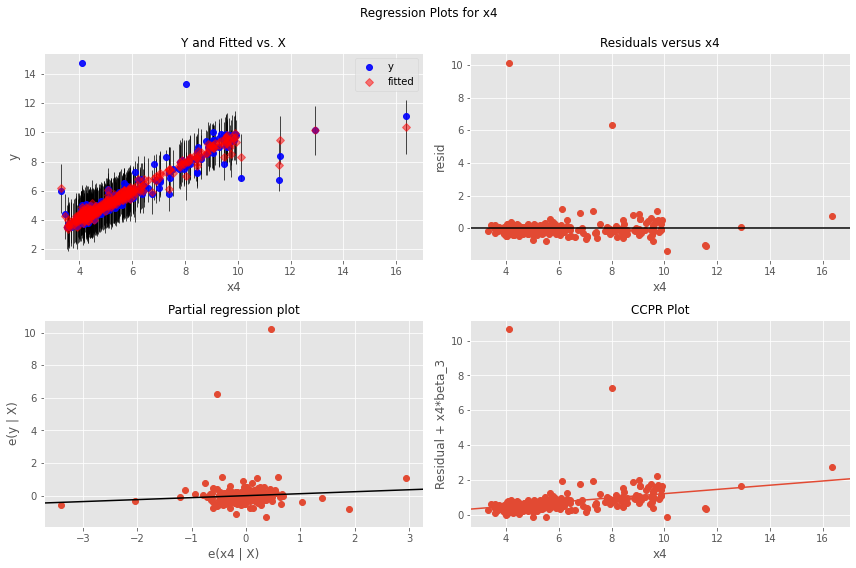

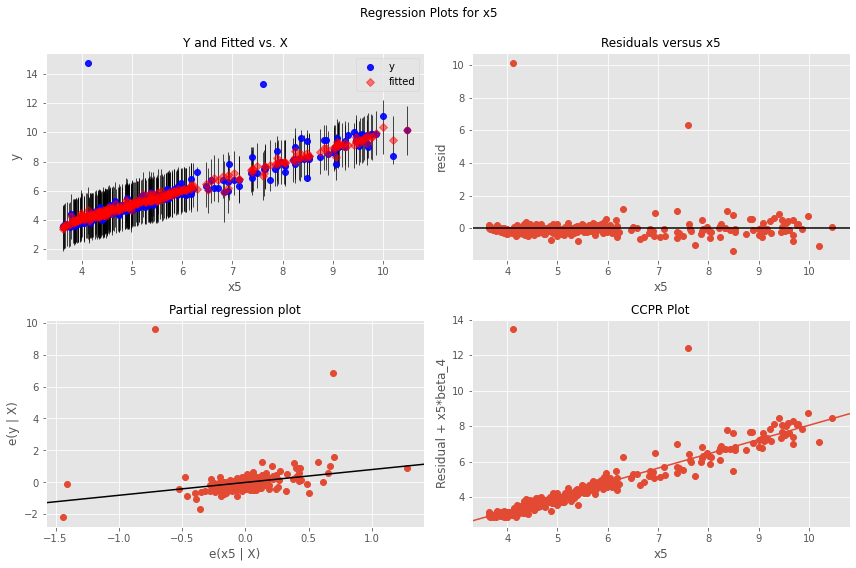

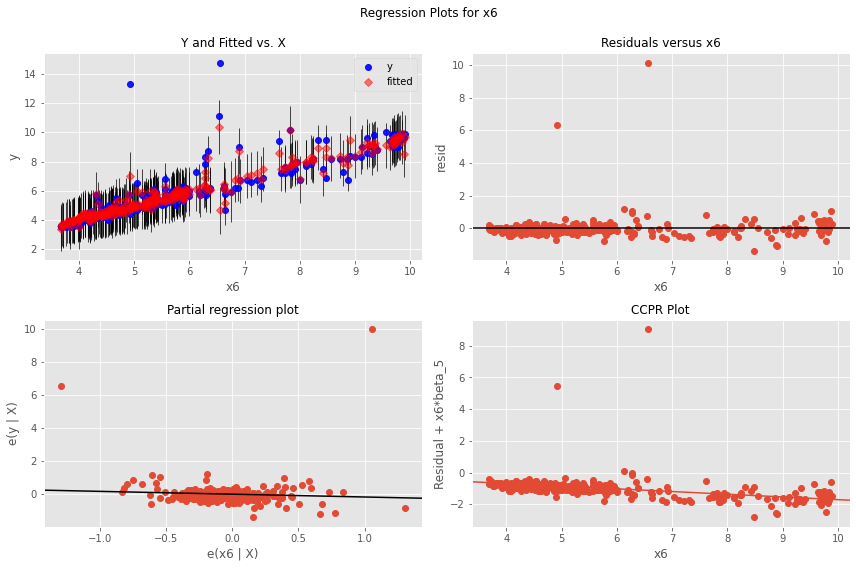

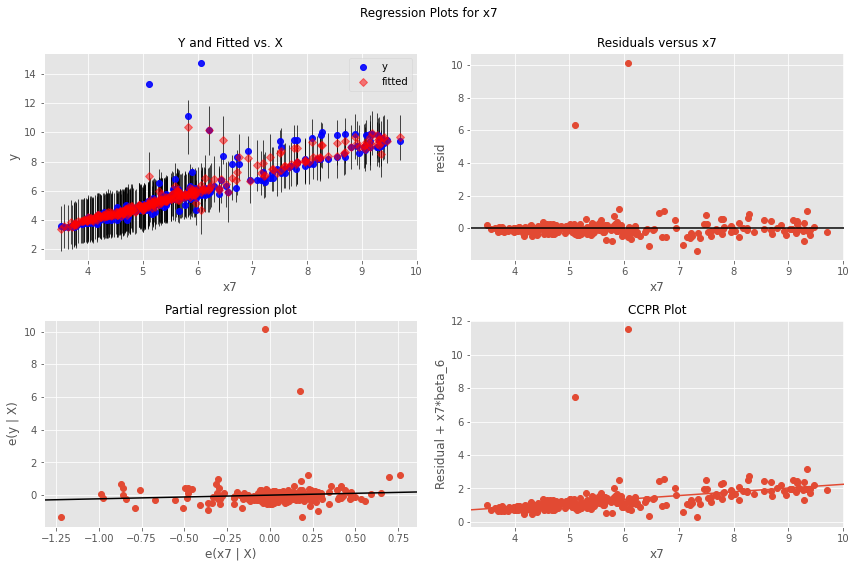

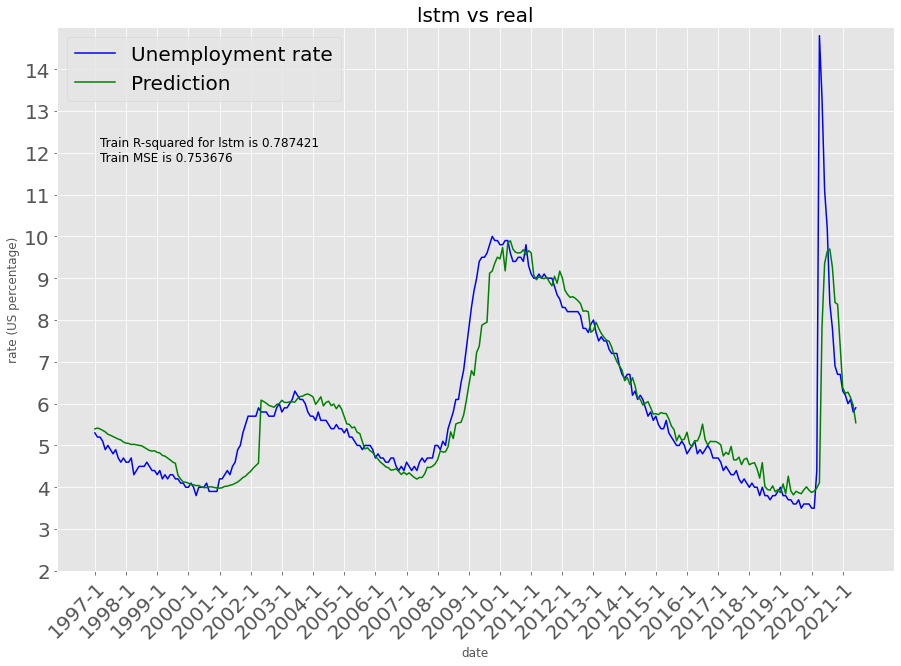

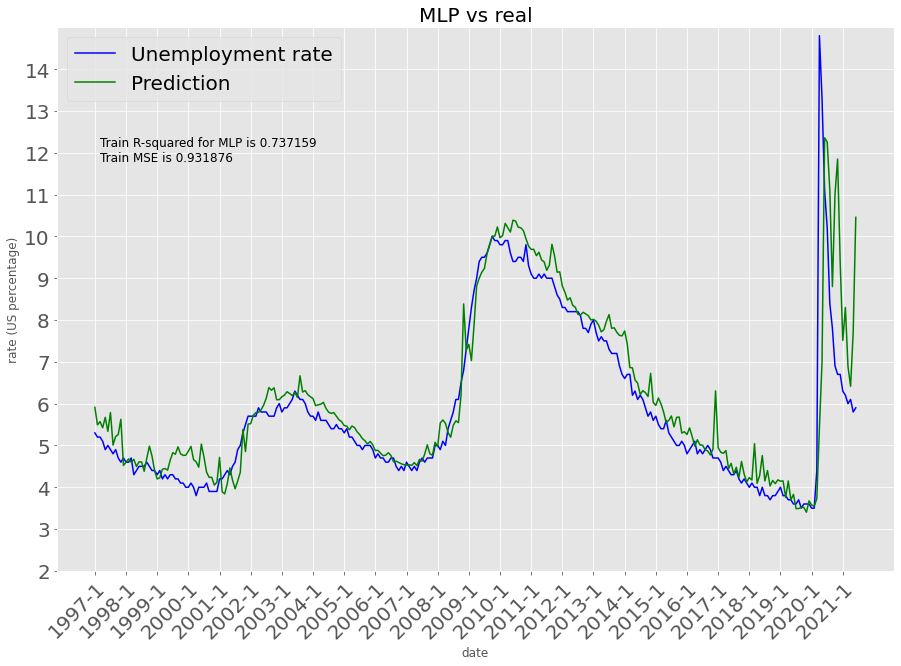

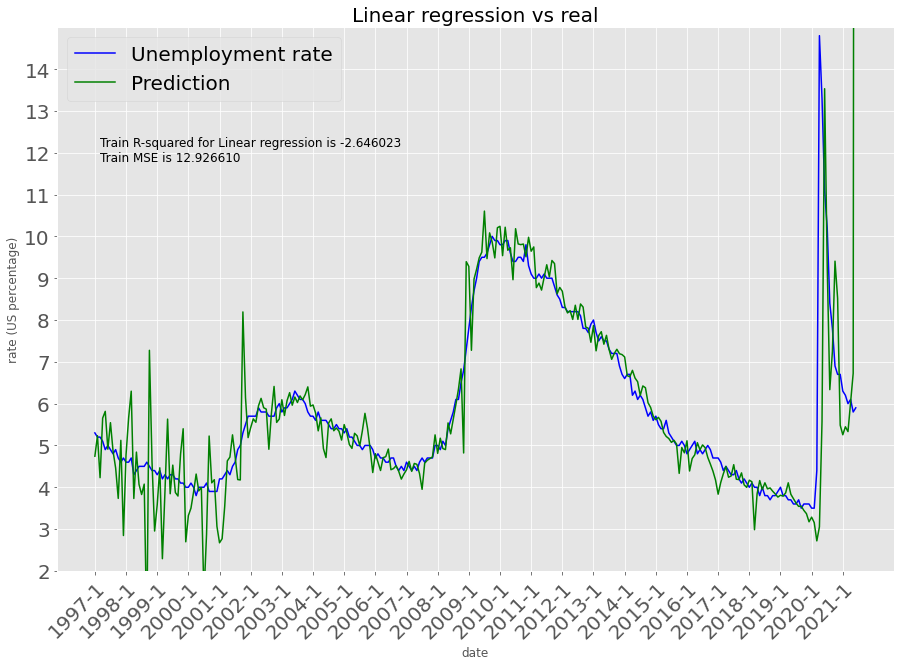

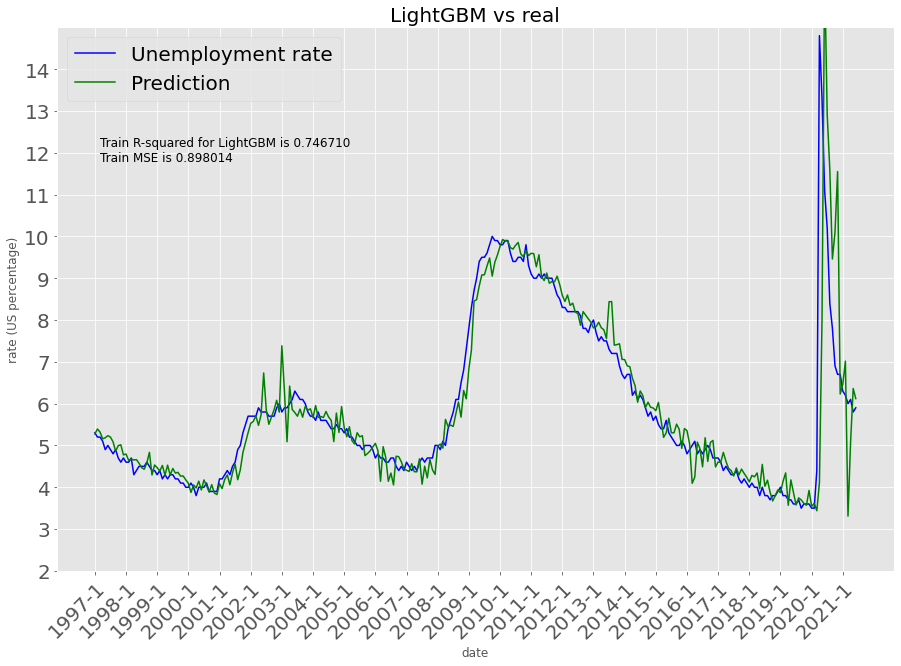

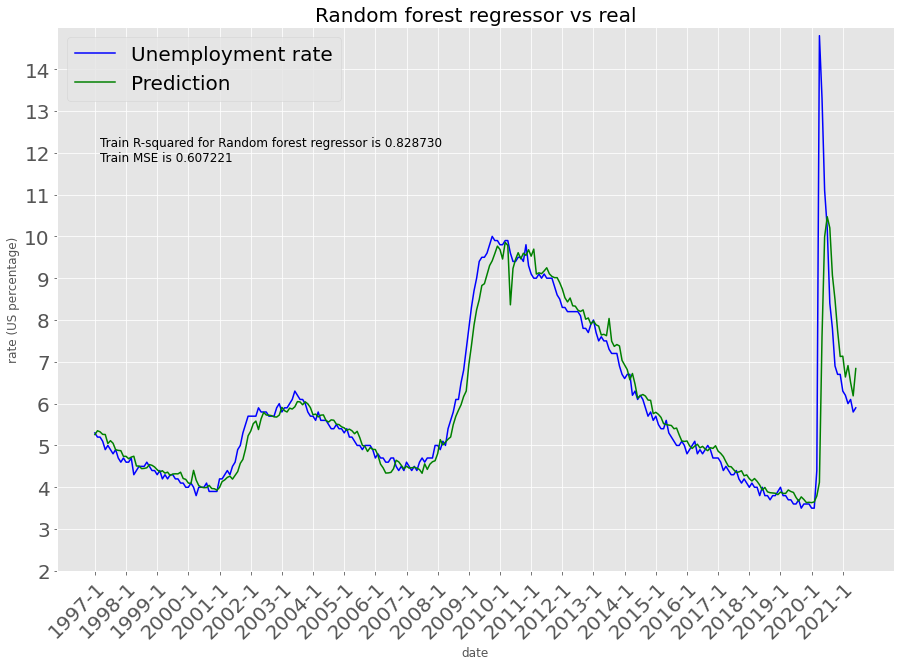

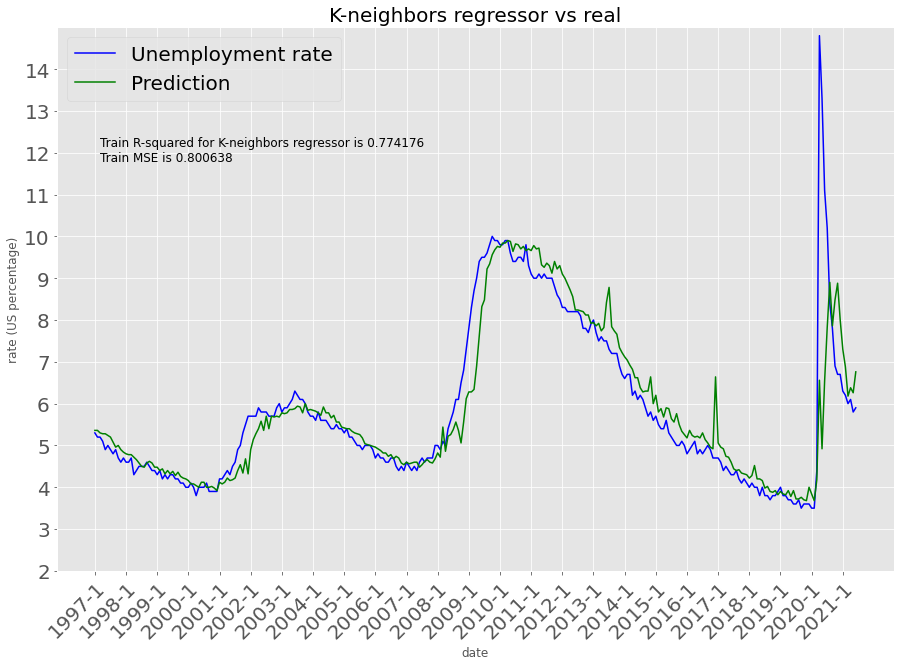

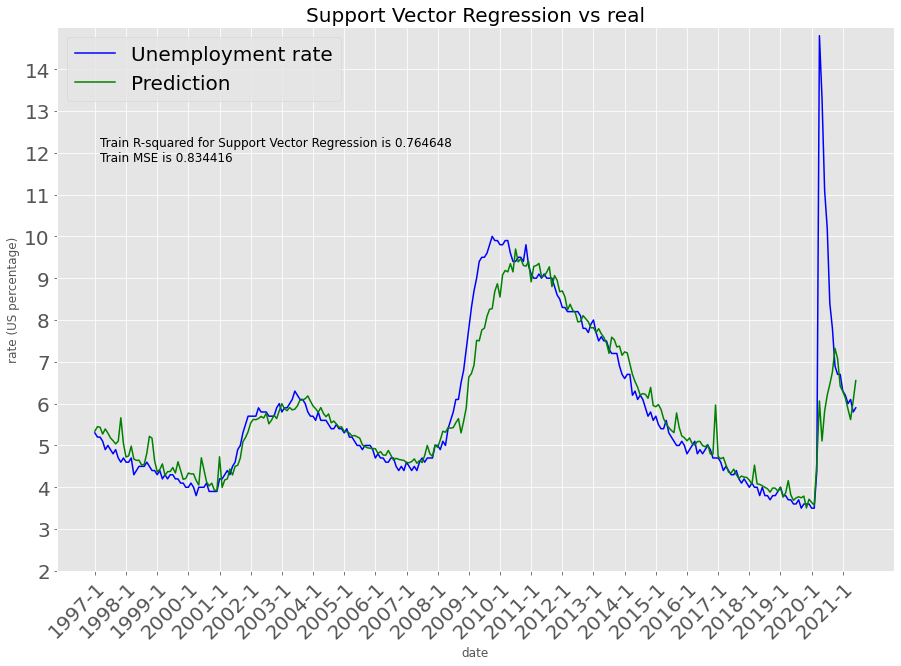

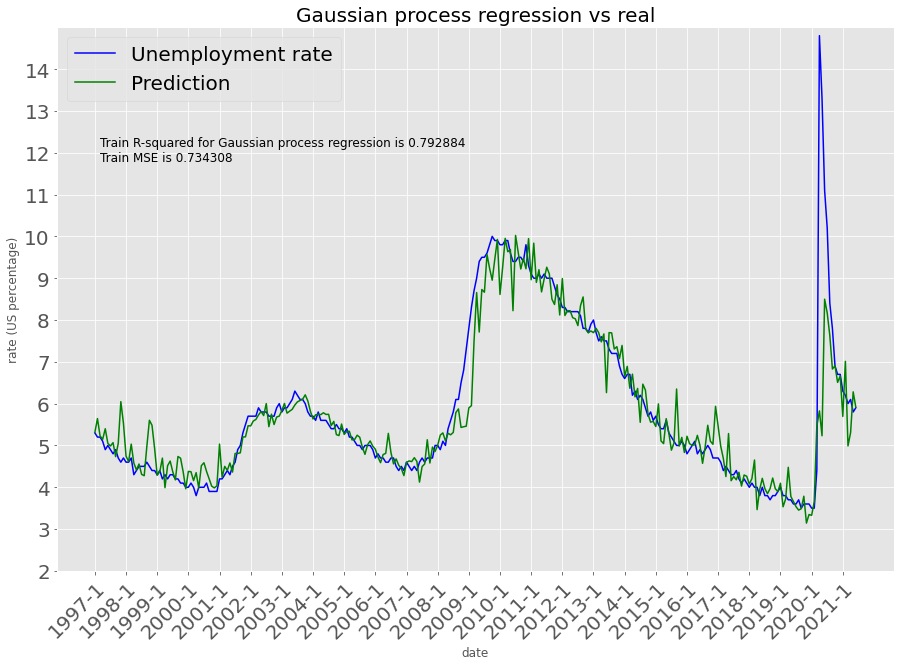

In [376]:
model_names = ["lstm", "MLP", "Linear regression", "LightGBM",
               "Random forest regressor", "K-neighbors regressor",
               "Support Vector Regression", "Gaussian process regression"]
chart_details_dict = {i: {"title": model_names[i] + " vs real",
                          "save_as": "pred" + str(i),
                          "model_name": model_names[i]}
                      for i in range(len(model_names))}
make_graph(All_data, stack_preds, True)
for i in range(len(X_train_level2[0])):
    make_graph(All_data, X_train_level2[:, i], **chart_details_dict[i])


In [42]:
for item in zip(rf.feature_importances_, All_data.columns):
    print(item)


(0.0019431065170580698, 'UNRATE')
(0.00014228371943941258, 'Year')
(0.0009158406798148563, 'Month')
(0.00015523319858071858, '10YRTREASURYmean')
(0.0022269064420698944, '10YRTREASURYstd')
(9.224002682154252e-05, 'FEDFUNDRATEmean')
(5.605873000880896e-05, 'FEDFUNDRATEstd')
(0.001284267641958282, 'M2REAL')
(0.0024732889151027632, 'MORTGAGE30USmean')
(0.0013653512437007092, 'MORTGAGE30USstd')
(0.0024568278808112963, 'VIXCLSmean')
(0.0006932406840622675, 'VIXCLSstd')
(0.0008083251136251477, 'Date_block_num')
(0.0006170757536749823, 'USSTHPI')
(0.00019629354890903335, 'REALGDPUS')
(0.0005504646367414692, 'REALGDPPCUS')
(7.096505964385463e-05, 'GPDIC1')
(0.004517003993172927, '10YRTREASURYmean_dot_10YRTREASURYstd')
(0.00029865341910525296, '10YRTREASURYmean_dot_FEDFUNDRATEmean')
(0.00028273718033053314, '10YRTREASURYmean_dot_FEDFUNDRATEstd')
(0.00031622433820951957, '10YRTREASURYmean_dot_M2REAL')
(0.0003146476070631149, '10YRTREASURYmean_dot_MORTGAGE30USmean')
(0.005053865696376539, '10YRTRE